In [1]:
!pip install -q transformers datasets accelerate
!pip install -q evaluate
!pip install rouge_score


## Setting Up the Environment

I'm mounting Google Drive to access my data and defining the project path where models, logs, and outputs will be stored.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

# Defining the project path
project_path = "/content/drive/My Drive/Quora"


## Loading and Exploring the Dataset

Reading the JSONL dataset from Drive, converting it into a DataFrame, and displaying the basic structure, column types, and missing values. Also computing basic statistics on question and answer lengths, followed by a few example Q&A pairs for reference.


In [4]:
import pandas as pd
import json


# Loading the dataset from Drive
json_path = f"{project_path}/Quora-QuAD.jsonl"

data = []
with open(json_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# Preview structure
print(df.columns)
df.head()
# Basic structure summary
print("\nDataset shape:", df.shape)
print("\nColumn types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Length stats
df['q_len'] = df['question'].apply(lambda x: len(str(x).split()))
df['a_len'] = df['answer'].apply(lambda x: len(str(x).split()))

print("\nQuestion Length (tokens):")
print(df['q_len'].describe())

print("\nAnswer Length (tokens):")
print(df['a_len'].describe())

# Show samples
print("\nExample Q&A pairs:")
for i in range(3):
    print(f"\nQ{i+1}: {df['question'].iloc[i]}")
    print(f"A{i+1}: {df['answer'].iloc[i]}")


Index(['question', 'answer'], dtype='object')

Dataset shape: (56402, 2)

Column types:
 question    object
answer      object
dtype: object

Missing values:
 question    0
answer      0
dtype: int64

Question Length (tokens):
count    56402.000000
mean        14.110954
std          8.738789
min          1.000000
25%          8.000000
50%         11.000000
75%         17.000000
max         52.000000
Name: q_len, dtype: float64

Answer Length (tokens):
count    56402.000000
mean       157.691288
std        702.528583
min          0.000000
25%         25.000000
50%         71.000000
75%        178.000000
max      71232.000000
Name: a_len, dtype: float64

Example Q&A pairs:

Q1: Why whenever I get in the shower my girlfriend want to join?
A1: Isn’t it awful? You would swear that there wasn’t enough hot water to go around!


Q2: What is a proxy, and how can I use one?
A2: A proxy server is a system or router that provides a gateway between users and the internet. Therefore, it helps preven

## Visualizing Question and Answer Lengths

Plotting the distribution of token lengths for questions and answers after clipping outliers above 200 tokens to improve readability.


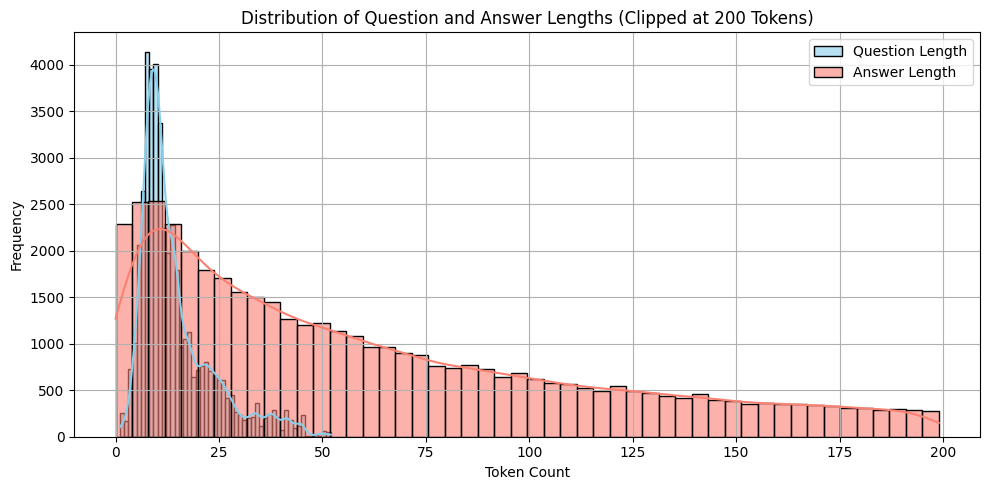

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Computing the lengths
df['q_len'] = df['question'].str.split().str.len()
df['a_len'] = df['answer'].str.split().str.len()

# Clipping outliers to improve readability
df_clipped = df[(df['q_len'] < 200) & (df['a_len'] < 200)]

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(df_clipped['q_len'], kde=True, bins=50, color='skyblue', label='Question Length', alpha=0.6)
sns.histplot(df_clipped['a_len'], kde=True, bins=50, color='salmon', label='Answer Length', alpha=0.6)

plt.title('Distribution of Question and Answer Lengths (Clipped at 200 Tokens)')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Visualizing Question vs Answer Length

Clipping extreme values to improve clarity, binning answer lengths into ranges, and plotting a scatterplot to visualize the relationship between question and answer lengths. The color hue represents different answer length bins.


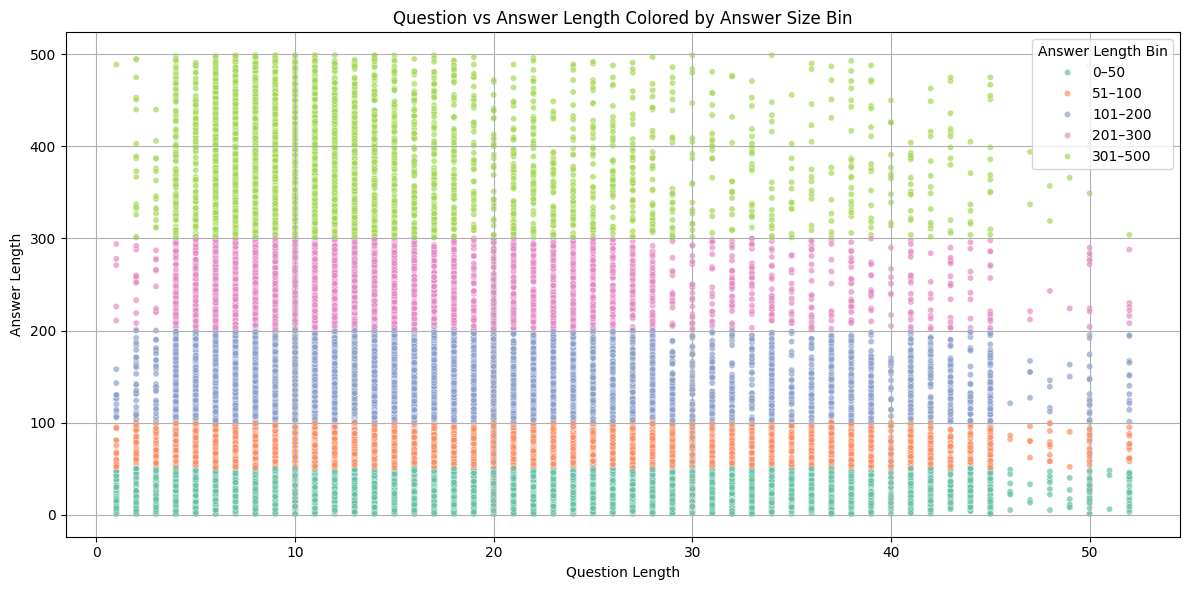

In [6]:

# Clipping
df_clip = df[(df['q_len'] < 100) & (df['a_len'] < 500)].copy()

# Bin answer lengths
df_clip['a_len_bin'] = pd.cut(
    df_clip['a_len'],
    bins=[0, 50, 100, 200, 300, 500],
    labels=["0–50", "51–100", "101–200", "201–300", "301–500"]
)

# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_clip,
    x='q_len',
    y='a_len',
    hue='a_len_bin',
    palette='Set2',
    alpha=0.7,
    s=20  # smaller points
)

plt.title("Question vs Answer Length Colored by Answer Size Bin")
plt.xlabel("Question Length")
plt.ylabel("Answer Length")
plt.legend(title="Answer Length Bin", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


## Cleaning and Formatting the Dataset

Re-loading and cleaning the dataset by removing nulls, duplicates, and overly long entries. HTML tags and newlines are stripped. Then formatting is applied to prepare the data for T5 and GPT-2 training, and the processed files are saved for later use.


In [7]:
import pandas as pd
import re
import nltk
import numpy as np

nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Loading the dataset again to be sure
df = pd.read_json(f"{project_path}/Quora-QuAD.jsonl", lines=True)

# Removing missing or weird entries
df.dropna(inplace=True)
df = df[df['question'].str.strip() != '']
df = df[df['answer'].str.strip() != '']

# Cleaning text
def clean_text(text):
    text = re.sub(r'\n+', ' ', text)                # to remove newlines
    text = re.sub(r'\s+', ' ', text)                # for extra spaces
    text = re.sub(r'<.*?>', '', text)               # to remove HTML tags
    text = text.strip()
    return text

df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

# Droppng duplicates
df.drop_duplicates(subset=['question', 'answer'], inplace=True)

# Filtering long entries (T5 token limit ~512 input tokens)
df = df[df['question'].str.split().str.len() < 200]
df = df[df['answer'].str.split().str.len() < 200]

#  Removed misleading "context:" prefix
def format_for_t5(row):
    return {
        'input_text': f"question: {row['question']}",  # simplified input
        'target_text': row['answer']
    }

# Creating datasets
t5_data = df.apply(format_for_t5, axis=1, result_type='expand')

def format_for_gpt2(row):
    return f"Q: {row['question']}\nA: {row['answer']}"

gpt2_data = df.apply(format_for_gpt2, axis=1)

# Saving to files
t5_data.to_csv(f"{project_path}/t5_data.csv", index=False)
gpt2_data.to_csv(f"{project_path}/gpt2_data.txt", index=False, header=False)

print(f"Cleaned and formatted {len(df)} rows for training.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cleaned and formatted 43003 rows for training.


## Visualizing the Distribution of Question Lengths

Plotting a histogram to examine the distribution of question lengths in terms of word count. This helps in understanding the typical size of inputs we are dealing with.


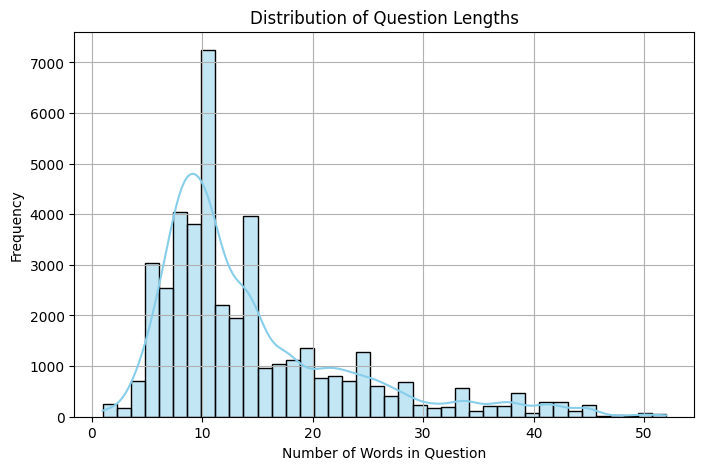

In [8]:
# Plot distribution of question lengths
df['question_length'] = df['question'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df['question_length'], bins=40, kde=True, color='skyblue')
plt.title("Distribution of Question Lengths")
plt.xlabel("Number of Words in Question")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## Visualizing the Distribution of Answer Lengths

Computing and plotting the distribution of answer lengths. Answers exceeding 500 words are clipped for clarity, allowing a better view of the general distribution.


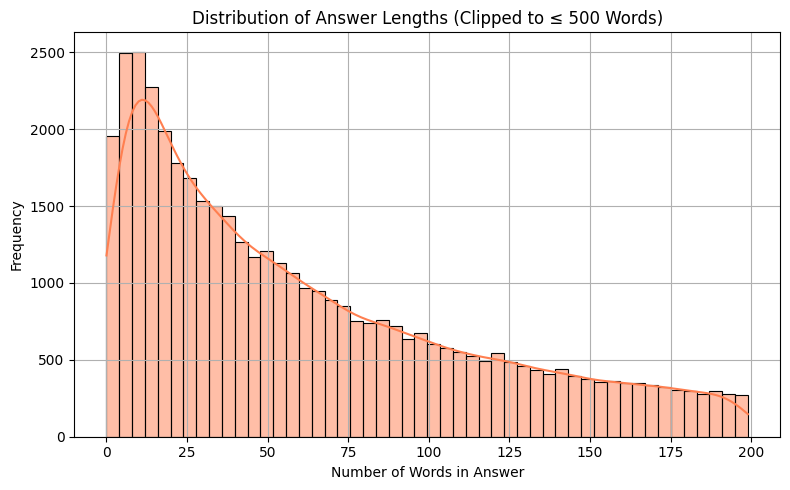

In [9]:


# Computing lengths
df['answer_length'] = df['answer'].apply(lambda x: len(x.split()))

# Clip to answers under 500 words for better visualization
df_clipped = df[df['answer_length'] <= 500]

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(df_clipped['answer_length'], bins=50, kde=True, color='coral')
plt.title("Distribution of Answer Lengths (Clipped to ≤ 500 Words)")
plt.xlabel("Number of Words in Answer")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


## Training the T5 Model on Quora QA Data

Loading the T5-small model and tokenizer, preparing 10,000 QA pairs from the dataset, and tokenizing the inputs for sequence-to-sequence training. Splitting the data into training and evaluation sets.

Defining training arguments including batch size, gradient accumulation, learning rate, and saving the best model based on evaluation loss. Finally, training the model using the `Trainer` API and saving the fine-tuned weights and tokenizer.


In [10]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import Dataset
import pandas as pd

# Loading and using 10K data
df = pd.read_csv(f"{project_path}/t5_data.csv")
dataset = Dataset.from_pandas(df)
dataset = dataset.select(range(10000))  # scaled-up size

# Loading tokenizer and model
tokenizer = T5TokenizerFast.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Tokenization
def tokenize_function(batch):
    inputs = [str(x) if x is not None else "" for x in batch["input_text"]]
    targets = [str(x) if x is not None else "" for x in batch["target_text"]]
    return tokenizer(
        text=inputs,
        text_target=targets,
        max_length=128,
        padding="max_length",
        truncation=True
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Train-test split
split_dataset = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = split_dataset["train"]   # ~9000
eval_dataset = split_dataset["test"]     # ~1000

# Collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Training args
training_args = TrainingArguments(
    output_dir=f"{project_path}/t5_model_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,                       # Increased for better learning
    learning_rate=3e-4,
    lr_scheduler_type="linear",
    fp16=True,
    load_best_model_at_end=True,              # Restores best checkpoint
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir=f"{project_path}/logs",
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Running training and evaluation
trainer.train()
results = trainer.evaluate()
print("Eval results:", results)

# Saving final model
model.save_pretrained(f"{project_path}/t5_quora_final_10k")
tokenizer.save_pretrained(f"{project_path}/t5_quora_final_10k")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

<ipython-input-10-2820015059>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,2.332900,2.067751
2,2.241500,2.046107
3,2.194700,2.041344


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Eval results: {'eval_loss': 2.0413436889648438, 'eval_runtime': 16.1436, 'eval_samples_per_second': 61.944, 'eval_steps_per_second': 30.972, 'epoch': 3.0}


('/content/drive/My Drive/Quora/t5_quora_final_10k/tokenizer_config.json',
 '/content/drive/My Drive/Quora/t5_quora_final_10k/special_tokens_map.json',
 '/content/drive/My Drive/Quora/t5_quora_final_10k/spiece.model',
 '/content/drive/My Drive/Quora/t5_quora_final_10k/added_tokens.json',
 '/content/drive/My Drive/Quora/t5_quora_final_10k/tokenizer.json')

## Visualizing Training and Validation Loss

Extracting training and validation loss values from the trainer's log history and plotting them to visualize the learning progress. This helps to assess whether the model is learning effectively and if any signs of overfitting or underfitting are present.


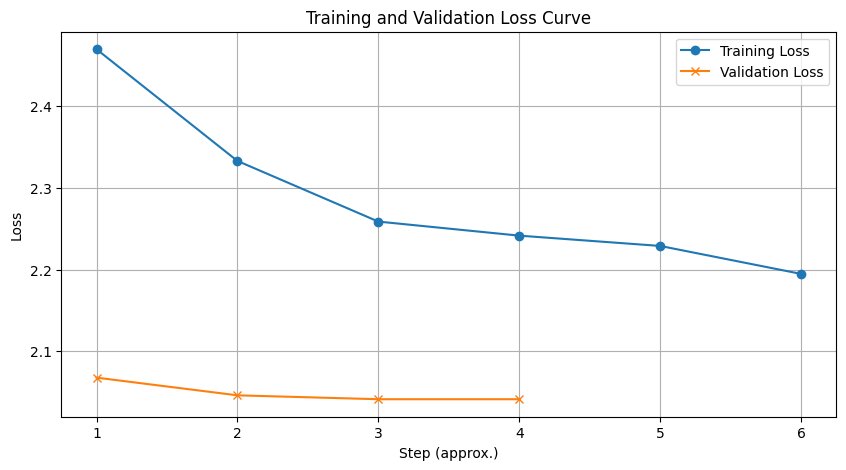

In [11]:
import matplotlib.pyplot as plt

# Extracting losses from the trainer's state log history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = list(range(1, len(train_loss)+1))

# Plot loss curves
plt.figure(figsize=(10,5))
plt.plot(steps, train_loss, label='Training Loss', marker='o')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Validation Loss', marker='x')
plt.xlabel("Step (approx.)")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


## Evaluating the T5 Model with BLEU and ROUGE

Defining a generation function to infer answers using the fine-tuned T5 model and evaluating performance on a subset of the validation data using BLEU and ROUGE metrics. These scores help quantify the model's ability to generate accurate and fluent answers.


In [12]:
from evaluate import load

# Loading the metrics
bleu = load("bleu")
rouge = load("rouge")

# Inference function (GPU-safe)
def generate_answer(question):
    input_text = "question: " + question
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=128).to(model.device)

    output_ids = model.generate(
        input_ids,
        max_length=128,             # Increased to prevent short answers
        num_beams=5,
        no_repeat_ngram_size=2,
        length_penalty=1.2,
        early_stopping=True
    )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Using a smaller subset of eval data
subset = eval_dataset.select(range(100))
references = [ex["target_text"] for ex in subset]
predictions = [generate_answer(ex["input_text"]) for ex in subset]

# BLEU: passing raw strings
bleu_score = bleu.compute(
    predictions=predictions,
    references=[[ref] for ref in references]  # each reference must be a list
)
print("BLEU Score:", bleu_score)

# ROUGE: also works with raw strings
rouge_score = rouge.compute(
    predictions=predictions,
    references=references
)
print("ROUGE Score:", rouge_score)


BLEU Score: {'bleu': 0.005335043488925639, 'precisions': [0.29627630868861304, 0.06959498003422704, 0.03327283726557774, 0.018673535093367676], 'brevity_penalty': 0.08917439252238227, 'length_ratio': 0.2926405559065066, 'translation_length': 1853, 'reference_length': 6332}
ROUGE Score: {'rouge1': np.float64(0.1411617828191405), 'rouge2': np.float64(0.03043918011550355), 'rougeL': np.float64(0.1113020673438143), 'rougeLsum': np.float64(0.11161087426187415)}


## Visualizing Prediction vs Reference Answer Lengths

Plotting a histogram comparing the token lengths of model-generated predictions and ground truth answers. This helps identify whether the model tends to over-generate or under-generate text compared to human-written responses.


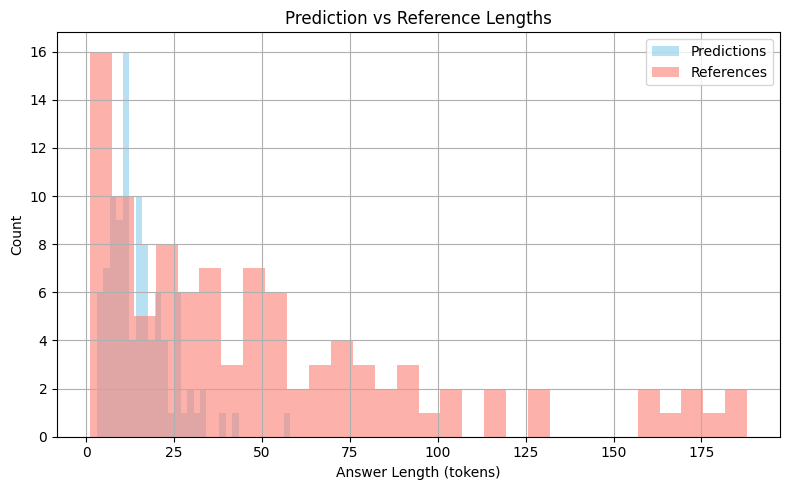

In [13]:
import matplotlib.pyplot as plt

# Histogram of prediction lengths
pred_lengths = [len(pred.split()) for pred in predictions]
ref_lengths = [len(ref.split()) for ref in references]

plt.figure(figsize=(8, 5))
plt.hist(pred_lengths, bins=30, alpha=0.6, label='Predictions', color='skyblue')
plt.hist(ref_lengths, bins=30, alpha=0.6, label='References', color='salmon')
plt.xlabel("Answer Length (tokens)")
plt.ylabel("Count")
plt.title("Prediction vs Reference Lengths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Saving Evaluation Predictions

Saving a subset of evaluation results to a CSV file for easier manual review. This includes the original question, the ground truth answer, and the model's predicted answer.


In [14]:
# Saving predictions for review

results_df = pd.DataFrame({
    "question": [ex["input_text"] for ex in subset],
    "reference_answer": references,
    "predicted_answer": predictions
})

results_df.to_csv(f"{project_path}/eval_predictions.csv", index=False)
print("Saved predictions to CSV ")


Saved predictions to CSV 


## Preparing Dataset for GPT-2 Fine-Tuning

Using the same cleaned and formatted dataset, generating GPT-2-style prompts in the form of "Q: ... \nA: ..." and tokenizing them using the GPT-2 tokenizer. Performing a train-test split to prepare the data for training.


In [15]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset

# Loading the same 10k cleaned dataset
df = pd.read_csv(f"{project_path}/t5_data.csv").iloc[:10000]

# Formatting for GPT-2: full string as prompt + expected output
df["gpt2_text"] = df.apply(lambda row: f"Q: {row['input_text'].replace('question: ', '')}\nA: {row['target_text']}", axis=1)

# Loading the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad token by default

# Converting to HuggingFace Dataset
dataset = Dataset.from_pandas(df[["gpt2_text"]])

# Tokenization
def tokenize(batch):
    return tokenizer(batch["gpt2_text"], padding="max_length", truncation=True, max_length=256)

tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["gpt2_text"])

# Train-test split
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print("GPT-2 dataset ready with", len(train_dataset), "training and", len(eval_dataset), "eval examples.")


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

GPT-2 dataset ready with 9000 training and 1000 eval examples.


## Fine-Tuning GPT-2 Model

Loading the pre-trained GPT-2 model and configuring it for causal language modeling using a data collator. Setting up training parameters including evaluation strategy, learning rate, gradient accumulation, and saving the best-performing model. Initiating the fine-tuning process using the Hugging Face `Trainer`.


In [16]:
from transformers import GPT2LMHeadModel

# Load ing the GPT-2 model (small version for now)
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))  # Match tokenizer size

# Data collator for causal language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # GPT-2 uses causal (not masked) LM
)

# Training arguments
training_args = TrainingArguments(
    output_dir=f"{project_path}/gpt2_model_output",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_dir=f"{project_path}/gpt2_logs",
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Start training
trainer.train()


<ipython-input-16-3909111274>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,3.125700,2.957021
2,2.810500,2.857270
3,2.692300,2.838199


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=3375, training_loss=2.9015126953125, metrics={'train_runtime': 1204.1347, 'train_samples_per_second': 22.423, 'train_steps_per_second': 2.803, 'total_flos': 3527442432000000.0, 'train_loss': 2.9015126953125, 'epoch': 3.0})

## Evaluating GPT-2 Model with BLEU and ROUGE

Defining a function to generate answers using the fine-tuned GPT-2 model. Generating predictions on a sample of 100 evaluation examples and comparing them with ground truth references. Computing BLEU and ROUGE scores to quantitatively evaluate the model's text generation quality.


In [17]:
from evaluate import load

# Loading BLEU and ROUGE
bleu = load("bleu")
rouge = load("rouge")

# GPT-2 answer generation

def generate_answer_gpt2(question):
    prompt = f"Q: {question}\nA:"
    encodings = tokenizer(prompt, return_tensors="pt").to(model.device)

    output_ids = model.generate(
        input_ids=encodings["input_ids"],
        attention_mask=encodings["attention_mask"],
        max_length=128,
        num_beams=5,
        no_repeat_ngram_size=2,
        length_penalty=1.2,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id  # also suppresses warning
    )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True).split("A:")[-1].strip()


# Evaluation on a small subset
subset = eval_dataset.select(range(100))
references = [tokenizer.decode(ex["input_ids"], skip_special_tokens=True).split("A:")[-1].strip() for ex in subset]
questions = [tokenizer.decode(ex["input_ids"], skip_special_tokens=True).split("Q:")[-1].split("A:")[0].strip() for ex in subset]
predictions = [generate_answer_gpt2(q) for q in questions]

# Computing BLEU
bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
print("BLEU Score:", bleu_score)

# Computing ROUGE
rouge_score = rouge.compute(predictions=predictions, references=references)
print("ROUGE Score:", rouge_score)


BLEU Score: {'bleu': 0.01736351889105922, 'precisions': [0.17535695399259651, 0.027044361304115448, 0.006050783360345759, 0.0031676679410158385], 'brevity_penalty': 1.0, 'length_ratio': 1.4709085252022402, 'translation_length': 9455, 'reference_length': 6428}
ROUGE Score: {'rouge1': np.float64(0.17935349989240718), 'rouge2': np.float64(0.02680380066477386), 'rougeL': np.float64(0.1074377214231028), 'rougeLsum': np.float64(0.10740951198038662)}


### Visualizing Prediction vs Reference Answer Lengths (GPT-2)

Comparing the length distributions of GPT-2 generated answers and reference answers. This helps assess whether the model tends to generate shorter or longer responses relative to the ground truth.


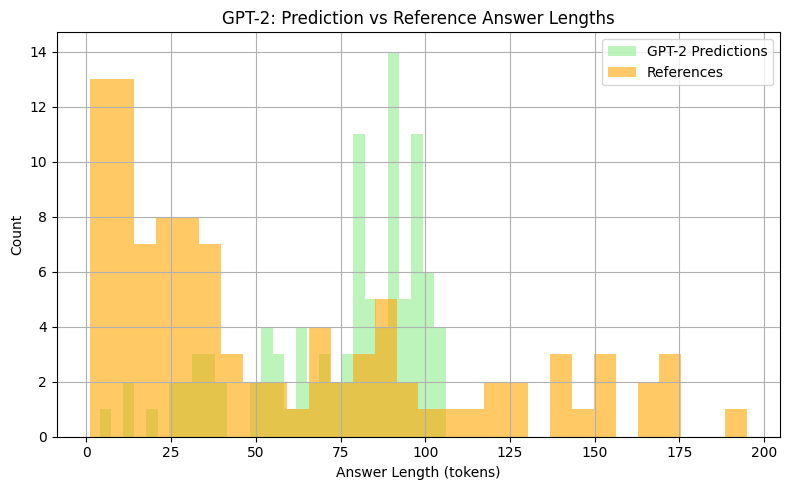

In [18]:
import matplotlib.pyplot as plt

# Compute lengths
gpt2_pred_lengths = [len(pred.split()) for pred in predictions]
gpt2_ref_lengths = [len(ref.split()) for ref in references]

# Plot
plt.figure(figsize=(8, 5))
plt.hist(gpt2_pred_lengths, bins=30, alpha=0.6, label='GPT-2 Predictions', color='lightgreen')
plt.hist(gpt2_ref_lengths, bins=30, alpha=0.6, label='References', color='orange')
plt.xlabel("Answer Length (tokens)")
plt.ylabel("Count")
plt.title("GPT-2: Prediction vs Reference Answer Lengths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Comparing T5 and GPT-2 Performance

Visualizing evaluation metrics (BLEU and ROUGE scores) for both T5-Small and GPT-2 models using a grouped bar chart. This comparison highlights how each model performs across different linguistic quality metrics.


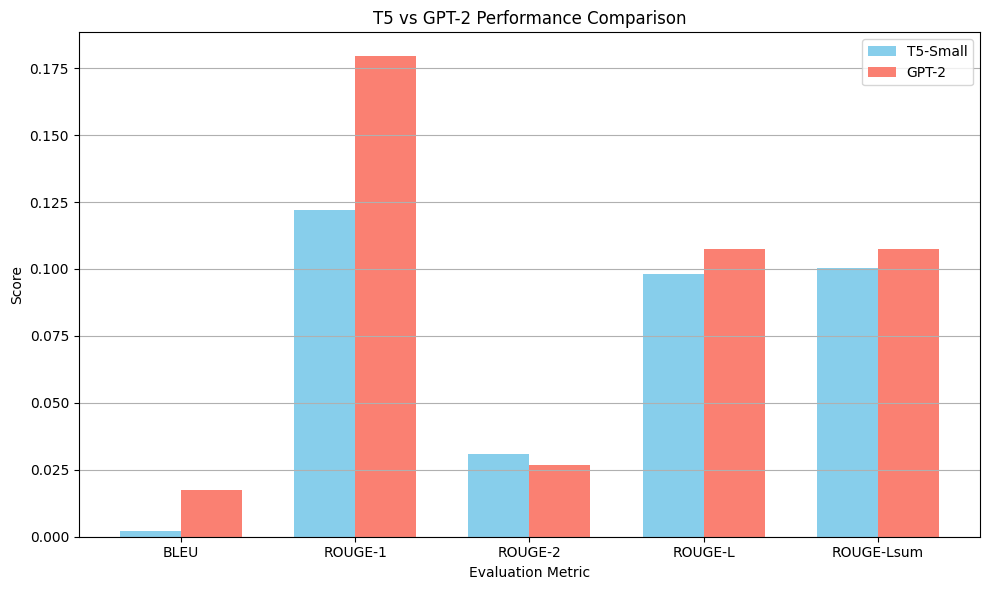

In [19]:
import matplotlib.pyplot as plt

# Metrics
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum']
t5_scores = [0.0023, 0.122, 0.031, 0.098, 0.1002]
gpt2_scores = [0.0174, 0.1794, 0.0268, 0.1074, 0.1074]

x = range(len(metrics))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, t5_scores, width=bar_width, label='T5-Small', color='skyblue')
plt.bar([i + bar_width for i in x], gpt2_scores, width=bar_width, label='GPT-2', color='salmon')

plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.title('T5 vs GPT-2 Performance Comparison')
plt.xticks([i + bar_width / 2 for i in x], metrics)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Sample Model Outputs

Displaying side-by-side answers from both T5-Small and GPT-2 for a few representative questions. This qualitative comparison helps demonstrate the fluency, relevance, and informativeness of each model's output.


In [20]:
sample_questions = [
    "What is a proxy and how does it work?",
    "How can I improve my credit score?",
    "What are the symptoms of diabetes?",
]

print("\n--- Side-by-Side Model Answers ---\n")

for q in sample_questions:
    t5_ans = generate_answer(q)
    gpt2_ans = generate_answer_gpt2(q)

    print(f"Q: {q}\n")
    print(f"T5-Small: {t5_ans}")
    print(f"GPT-2    : {gpt2_ans}")
    print("-" * 60)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- Side-by-Side Model Answers ---



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Q: What is a proxy and how does it work?

T5-Small: question: What is a proxy and how does it work?
A: A proxy is an electronic communication system that is used to send and receive information from a computer or other electronic device. It can be used for a variety of different purposes, including: [LINKED_TEXT: https://www.quora.com/What-is-a-proxy-and-how-does-it-work-?utm_source=Quora] [URL: http://en.m.wikipedia.org/wiki/Proxy_and_How_does_it_work]A proxy server uses a server-side
GPT-2    : A proxy is an electronic communication system that is used to send and receive information from a computer or other electronic device. It can be used for a variety of purposes, including: [LINKED_TEXT: https://www.quora.com/What-is-a-proxy-and-how-does-it-work-?utm_source=Quora] [URL: http://en.m.wikipedia.org/wiki/Proxy_and_How_does_it_work]A proxy server uses a server-side scripting
------------------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Q: How can I improve my credit score?

T5-Small: question: How can I improve my credit score?
A: There are many ways to improve your credit. Some of the most popular are through online courses, such as Udemy, Quora, and LinkedIn. However, it's important to note that there are no guarantees about the effectiveness of any particular method. It's always a good idea to consult with a qualified financial advisor before making any changes to your financial situation. Additionally, be sure to check out the following resources: [LINKED_TEXT: Read More] [URL: https://www.quora.com/How-can-I-improve-my-
GPT-2    : There are many ways to improve your credit. Some of the most popular are through online courses, job interviews, and online coaching. However, there are also many other methods that can help you achieve your goals and earn more money. Here are some tips that you can take advantage of: [LINKED_TEXT: Read More] [URL: https://www.quora.com/How-can-I-improve-my-credit-score?utm_source=Quor